# Tracing ttnn operations and torch modules/functions

In [ ]:
import os
os.environ["TTNN_CONFIG_OVERRIDES"] = "{\"enable_fast_runtime_mode\": false}"

In [ ]:
import torch
import transformers

import ttnn
from ttnn.tracer import trace, visualize

In [ ]:
transformers.logging.set_verbosity_error()

## Trace torch functions

In [ ]:
with trace():
    tensor = torch.randint(0, 100, (1, 64))
    tensor = torch.exp(tensor)
visualize(tensor)

ValueError: Tracing is already enabled.

## Trace torch functions and ttnn operations

2025-06-26 04:23:47.219 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


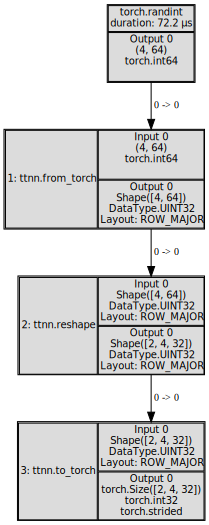

In [ ]:
with trace():
    tensor = torch.randint(0, 100, (4, 64))
    tensor = ttnn.from_torch(tensor)
    tensor = ttnn.reshape(tensor, (2, 4, 32))
    tensor = ttnn.to_torch(tensor)
visualize(tensor)

## Trace torch functions, torch modules and ttnn operations

In [ ]:
model_name = "google/bert_uncased_L-4_H-256_A-4"
config = transformers.BertConfig.from_pretrained(model_name)
model = transformers.models.bert.modeling_bert.BertSelfOutput(config).eval()

with trace():
    hidden_states = torch.rand((1, 64, config.hidden_size))
    input_tensor = torch.rand((1, 64, config.hidden_size))
    hidden_states = model(hidden_states, input_tensor)
    output = ttnn.from_torch(hidden_states)
visualize(output)

/home/maxim_artemov/workspace/tt-metal/python_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ValueError: Cannot assign non-leaf Tensor to parameter 'weight'. Model parameters must be created explicitly. To express 'weight' as a function of another Tensor, compute the value in the forward() method.

## Trace models written using ttnn

In [ ]:
dispatch_core_type = ttnn.device.DispatchCoreType.ETH
if "grayskull" in os.environ.get("ARCH_NAME"):
    dispatch_core_type = ttnn.device.DispatchCoreType.WORKER
device = ttnn.open_device(device_id=0, l1_small_size=8192, dispatch_core_config=ttnn.device.DispatchCoreConfig(dispatch_core_type))

[2025-06-25 05:29:21.811] [info] [pci_device.cpp:191] [SiliconDriver] Opened PCI device 0; KMD version: 2.0.0, IOMMU: disabled
[2025-06-25 05:29:21.813] [info] [pci_device.cpp:191] [SiliconDriver] Opened PCI device 0; KMD version: 2.0.0, IOMMU: disabled
[2025-06-25 05:29:21.821] [info] [tt_cluster.cpp:177] [Device] Opening user mode device driver
[2025-06-25 05:29:21.821] [info] [pci_device.cpp:191] [SiliconDriver] Opened PCI device 0; KMD version: 2.0.0, IOMMU: disabled
[2025-06-25 05:29:21.822] [info] [pci_device.cpp:191] [SiliconDriver] Opened PCI device 0; KMD version: 2.0.0, IOMMU: disabled
[2025-06-25 05:29:21.829] [info] [pci_device.cpp:191] [SiliconDriver] Opened PCI device 0; KMD version: 2.0.0, IOMMU: disabled
[2025-06-25 05:29:21.830] [info] [pci_device.cpp:191] [SiliconDriver] Opened PCI device 0; KMD version: 2.0.0, IOMMU: disabled
[2025-06-25 05:29:21.836] [info] [cluster.cpp:277] [SiliconDriver] Harvesting mask for chip 0 is 0x40 (physical layout: 0x40, logical: 0x40, si

In [ ]:
from models.demos.bert.tt import ttnn_bert
from models.demos.bert.tt import ttnn_optimized_bert
from ttnn.model_preprocessing import preprocess_model_parameters

def ttnn_bert(bert):
    model_name = "phiyodr/bert-large-finetuned-squad2"
    
    config = transformers.BertConfig.from_pretrained(model_name)
    config.num_hidden_layers = 1
    
    batch_size = 8
    sequence_size = 384
            
    parameters = preprocess_model_parameters(
        initialize_model=lambda: transformers.BertForQuestionAnswering.from_pretrained(
            model_name, config=config
        ).eval(),
        custom_preprocessor=bert.custom_preprocessor,
        device=device,
    )

    with trace():
        input_ids = torch.randint(0, config.vocab_size, (batch_size, sequence_size)).to(torch.int32)
        torch_token_type_ids = ttnn.zeros((batch_size, sequence_size), dtype=ttnn.int32)
        torch_position_ids = ttnn.zeros((batch_size, sequence_size), dtype=ttnn.int32)
        torch_attention_mask = ttnn.zeros(1, sequence_size) if bert == ttnn_optimized_bert else None
        

        ttnn_bert_inputs = bert.preprocess_inputs(
            input_ids,
            torch_token_type_ids,
            torch_position_ids,
            torch_attention_mask,
            device=device,
        )
    
        output = bert.bert_for_question_answering(
            config,
            *ttnn_bert_inputs,
            parameters=parameters,
        )
        output = ttnn.from_device(output)
        
    return visualize(output)

/home/maxim_artemov/workspace/tt-metal/python_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/478 [00:00<?, ?B/s]

2025-06-25 05:29:23.236 | DEBUG    | ttnn:manage_config:91 - Set ttnn.CONFIG.enable_logging to False
2025-06-25 05:29:23.237 | DEBUG    | ttnn:manage_config:91 - Set ttnn.CONFIG.enable_comparison_mode to False
2025-06-25 05:29:23.237 | WARNING  | ttnn.model_preprocessing:from_torch:533 - ttnn: model cache can be enabled by passing model_name argument to preprocess_model[_parameters] and setting env variable TTNN_CONFIG_OVERRIDES='{"enable_model_cache": true}'


pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

2025-06-25 05:29:35.981 | DEBUG    | ttnn.model_preprocessing:from_torch:612 - Moving model weights to device
2025-06-25 05:29:36.010 | DEBUG    | ttnn.model_preprocessing:from_torch:614 - Moved model weights to device
2025-06-25 05:29:36.011 | DEBUG    | ttnn:manage_config:94 - Restored ttnn.CONFIG.enable_comparison_mode to False
2025-06-25 05:29:36.011 | DEBUG    | ttnn:manage_config:94 - Restored ttnn.CONFIG.enable_logging to False


[2025-06-25 05:29:35.993] [warning] [graph_processor.cpp:280] [Always] Tensor doesn't have tensor_id, generating new one. Ideally this should not happen. Please set tensor_id for this tensor ahead of time.
[2025-06-25 05:29:36.002] [warning] [graph_processor.cpp:280] [Always] Tensor doesn't have tensor_id, generating new one. Ideally this should not happen. Please set tensor_id for this tensor ahead of time.
[2025-06-25 05:29:36.002] [warning] [graph_processor.cpp:280] [Always] Tensor doesn't have tensor_id, generating new one. Ideally this should not happen. Please set tensor_id for this tensor ahead of time.
[2025-06-25 05:29:36.003] [warning] [graph_processor.cpp:280] [Always] Tensor doesn't have tensor_id, generating new one. Ideally this should not happen. Please set tensor_id for this tensor ahead of time.
[2025-06-25 05:29:36.003] [warning] [graph_processor.cpp:280] [Always] Tensor doesn't have tensor_id, generating new one. Ideally this should not happen. Please set tensor_id f

2025-06-25 05:29:41.871 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


[2025-06-25 05:29:40.329] [warning] [graph_processor.cpp:280] [Always] Tensor doesn't have tensor_id, generating new one. Ideally this should not happen. Please set tensor_id for this tensor ahead of time.
[2025-06-25 05:29:41.337] [warning] [graph_processor.cpp:280] [Always] Tensor doesn't have tensor_id, generating new one. Ideally this should not happen. Please set tensor_id for this tensor ahead of time.
[2025-06-25 05:29:41.623] [warning] [graph_processor.cpp:280] [Always] Tensor doesn't have tensor_id, generating new one. Ideally this should not happen. Please set tensor_id for this tensor ahead of time.
[2025-06-25 05:29:41.623] [warning] [graph_processor.cpp:280] [Always] Tensor doesn't have tensor_id, generating new one. Ideally this should not happen. Please set tensor_id for this tensor ahead of time.


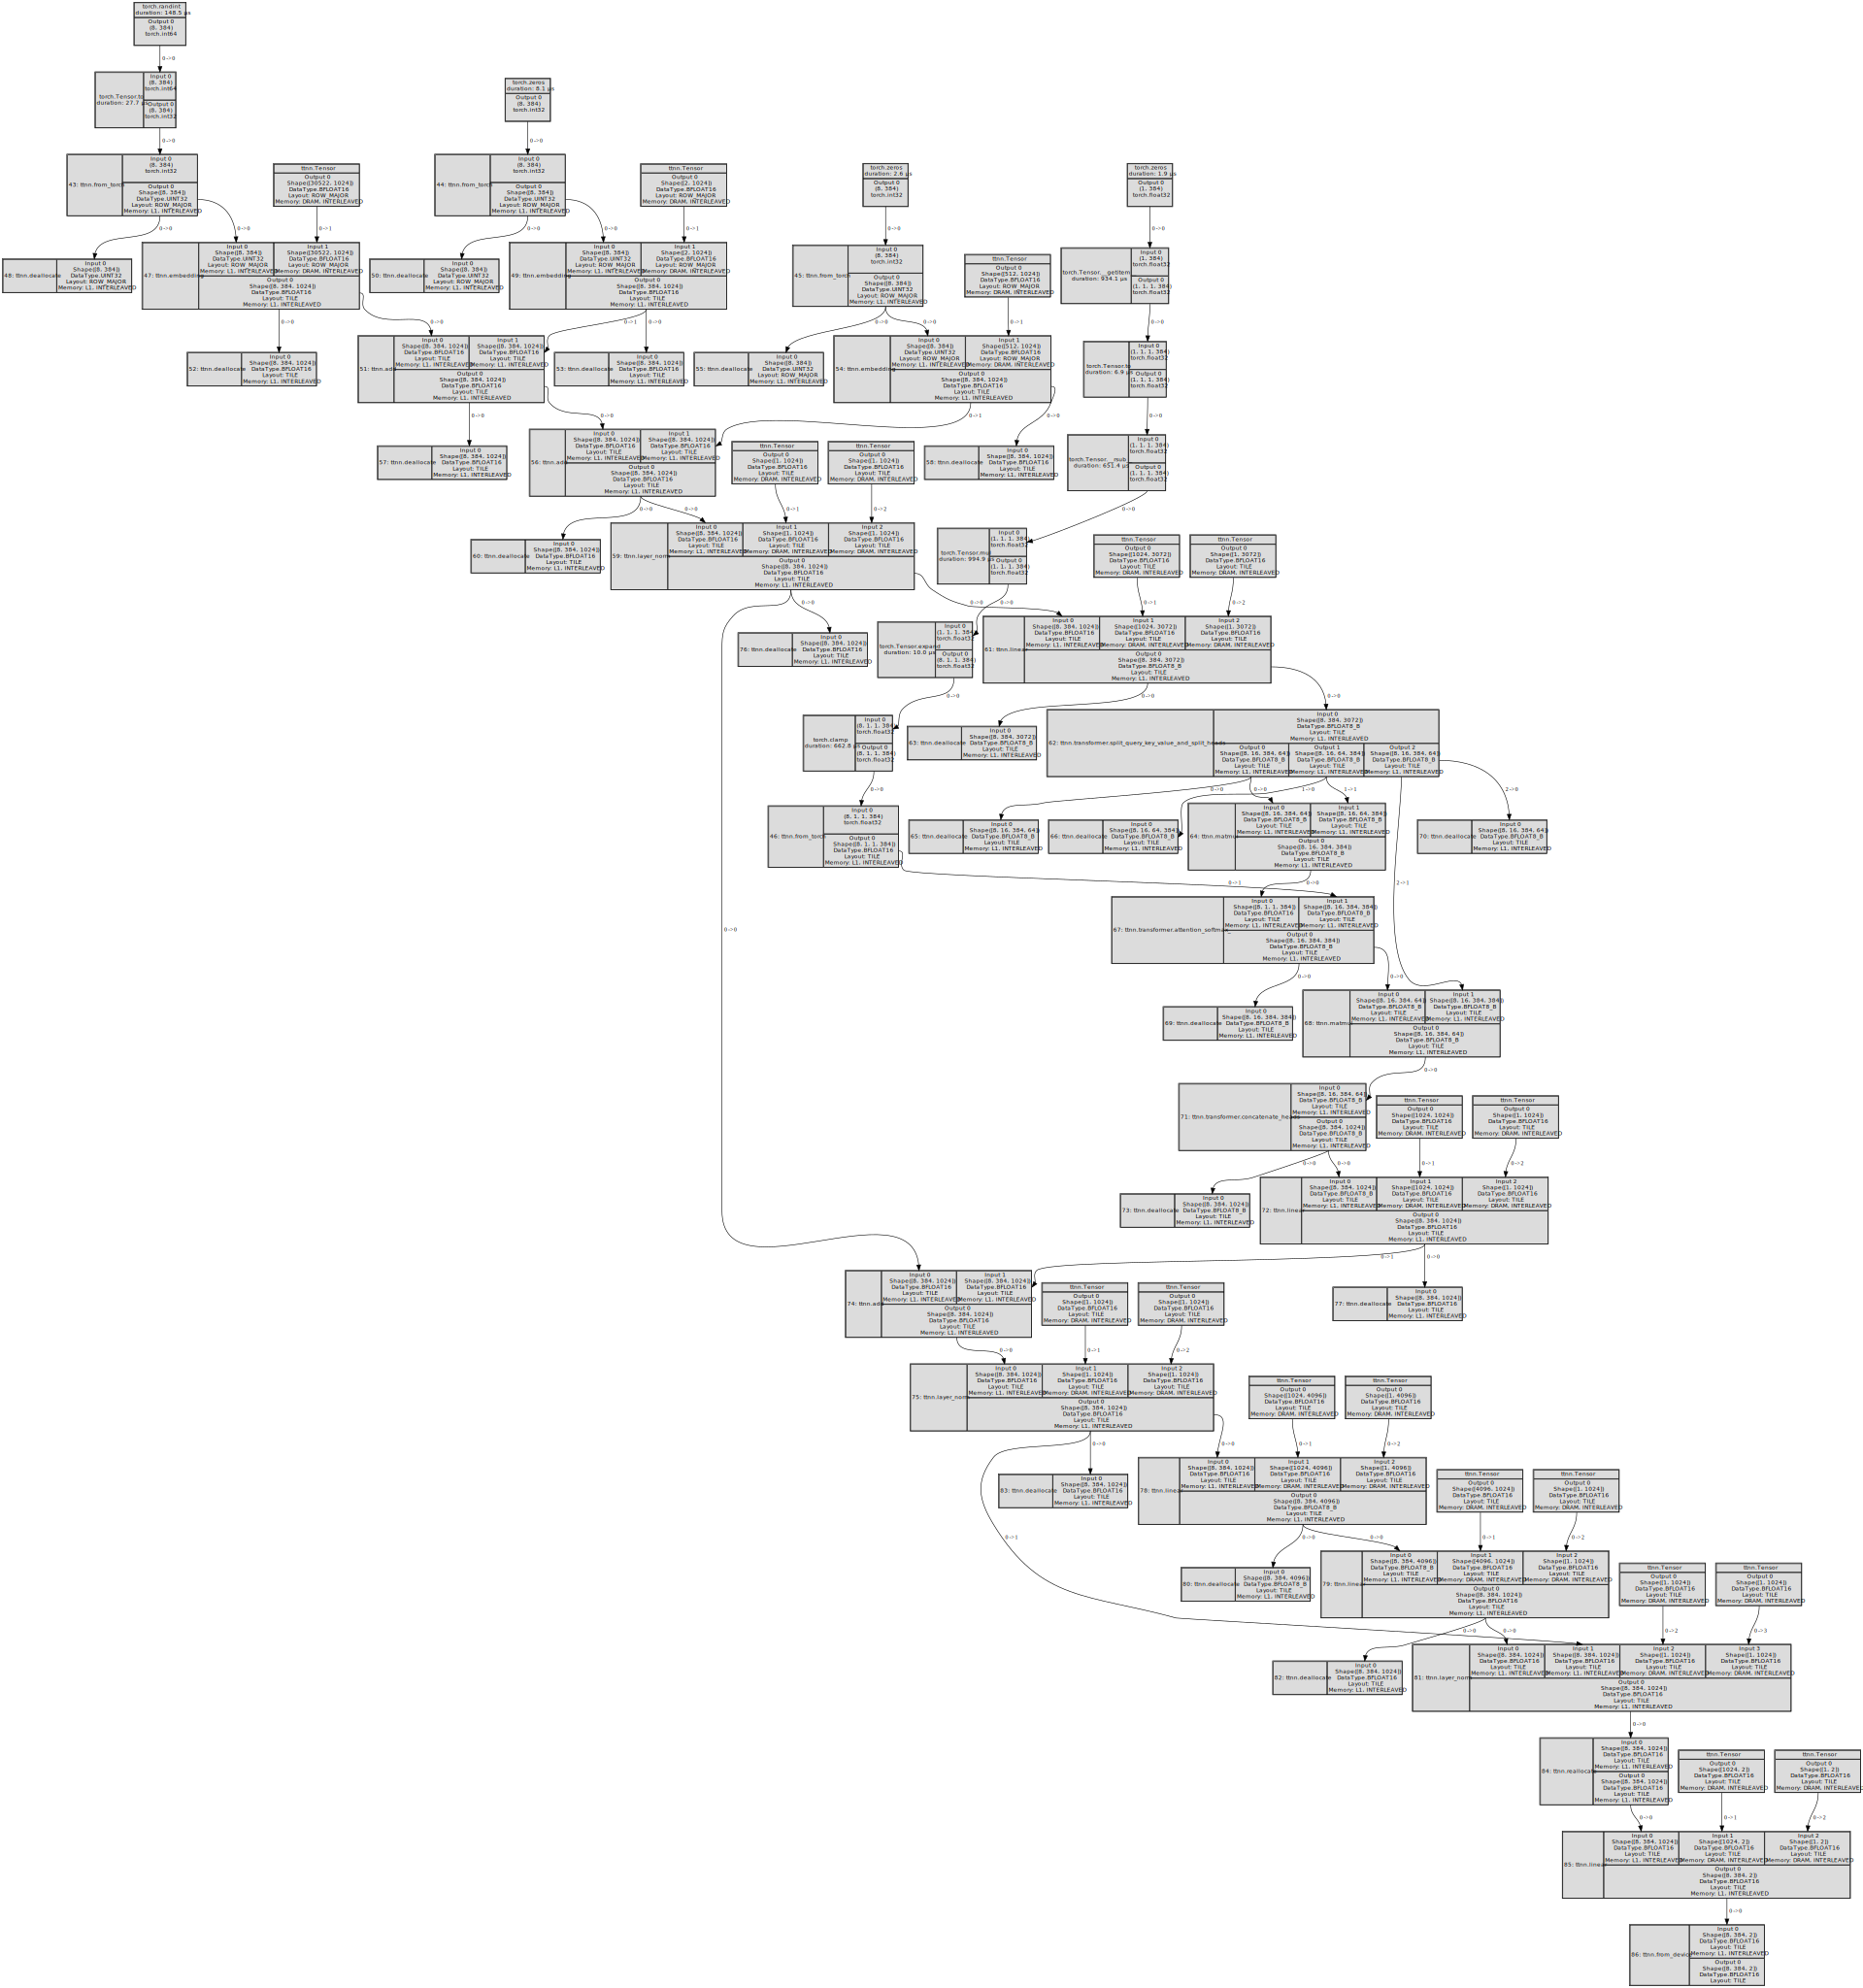

In [ ]:
ttnn_bert(ttnn_optimized_bert)

In [ ]:
ttnn.close_device(device)

[2025-06-25 05:29:42.644] [info] [device.cpp:1093] [Metal] Closing device 0
[2025-06-25 05:29:42.644] [info] [device.cpp:1440] [Metal] Disabling and clearing program cache on device 0
